In [1]:
using QuantumOptics
using WignerSymbols
using LinearAlgebra
using FFTW
using Plots
using LaTeXStrings
pyplot();

## Sub-Doppler Sisyphus cooling in a lin$\perp$lin molasses configuration
It turns out that if we use an atom with a more complicated electronic structe, we get sub-Doppler cooling through polarization gradients for free in this molasses configuration. 

#### Units
In cooling calculations it's convenient to express all frequencies in units of $\Gamma$, the natural line width. Furthermore, if we chose atomic units (by setting $\hbar = 1$) this means that we effectively solve $\tilde{\mathcal{H}}$, which is related to the original Hamiltonian $\mathcal{H}$ via: $\tilde{\mathcal{H}} = \mathcal{H}/\hbar\Gamma$.

The frequencies $\Omega$ and $\delta$ are understood to be in units of $\Gamma$. This becomes apparent when we look at the jump operator $L$, which, in these units, is simply given by: $L = |g\rangle\langle e|$. (In full units it would carry a factor $\sqrt{\Gamma}$). The full evolution of the density matrix $\rho$ is now given by the master equation
$$
    i\frac{d\rho}{dt} = \left[\mathcal{H}, \rho \right] + L\rho L^\dagger - \frac{1}{2} \left\{ L^\dagger L, \rho \right\}.
$$
(But we don't really need to bother with that since QuantumOptics.jl will do it for us.)

In [2]:
δ = -1.;
Ω = 0.3;
s₀ = 2 * Ω^2;

### Set up the basis
Because no default basis of QuantumOptics.jl is good for us, we'll just use a `GenericBasis` with the requisite number of states.

In [3]:
Fg = 1/2;
Fe = 3/2;
nStates = Int(2*(Fg + Fe) + 2);
gStates= [[Fg, mFg] for mFg in [-Fg:Fg;]];
eStates = [[Fe, mFe] for mFe in [-Fe:Fe;]];
states = [gStates; eStates];
sbasis = GenericBasis(nStates);

Calculate the couplings, and use them to calculate the matrix elements corresponding to the individual beams. We will use the fact that in this configuration we have standing waves of $\sigma_-$ and $\sigma_+$ polarization, which are out of phase by 90$^\circ$ (or a $\sin$ and a $\cos$).

In [4]:
σmincoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, -1, eStates[j][1], eStates[j][2] )] for i in [1:Int(2*Fg + 1);]] for j in [1:Int(2*Fe + 1);]];
σmincoupling = collect(Iterators.flatten(σmincoupling));

σpluscoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 1, eStates[j][1], eStates[j][2] )] for i in [1:Int(2*Fg + 1);]] for j in [1:Int(2*Fe + 1);]];
σpluscoupling = collect(Iterators.flatten(σpluscoupling));

In [5]:
VminMat = vcat(σmincoupling...);
Vminhalf = Ω / √(2) * SparseOperator(sbasis, complex(sparse(VminMat[:, 1], VminMat[:, 2], VminMat[:, 3], nStates, nStates)) );
Vmintot(z) = - sin(z) * ( Vminhalf + dagger(Vminhalf) );

VplusMat = vcat(σpluscoupling...);
Vplushalf = Ω / √(2) * SparseOperator(sbasis, complex(sparse(VplusMat[:, 1], VplusMat[:, 2], VplusMat[:, 3], nStates, nStates)) );
Vplustot(z) = cos(z) * (Vplushalf + dagger(Vplushalf) );

Define the Hamiltonian and force. The force is defined clasically as
$$
    F = -\langle \nabla\mathcal{H} \rangle.
$$

In [6]:
diagonalTerm = SparseOperator(sbasis, complex(Matrix(Diagonal([zeros(Int(2*Fg + 1)); ones(Int(2*Fe + 1))]))));

In [7]:
H(z) = Vmintot(z) + Vplustot(z) - δ * diagonalTerm;
F(z) = cos(z) * ( Vminhalf + dagger(Vminhalf) ) + sin(z) * ( Vplushalf - dagger(Vplushalf) );

### Decay, dephasing, and jump operators
We define the quantum jump operators by iterating over all the possible couplings. To that extent, we need the couplings by $\pi$ photons as well.  

In [8]:
πcoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 0, eStates[j][1], eStates[j][2] )] for i in [1:Int(2*Fg + 1);]] for j in [1:Int(2*Fe + 1);]];
πcoupling = collect(Iterators.flatten(πcoupling));

rate = [];
L = [];
for coupling in [σmincoupling; σpluscoupling; πcoupling]
    if coupling[3] > 0.
        append!(rate, coupling[3]);
        L = vcat(L, SparseOperator(sbasis, sparse([coupling[2]], [coupling[1]], complex([1.]), nStates, nStates)))
    end
end

rate = float.(rate)
Ldagger = dagger.(L);

### Setting up the time evolution and force calculation

There's somewhat of a conversion issue: because we enforce constant velocity, there is no such thing as a steady state. This is always the case when cooling off of a standing wave, so then the force is the average force over one cycle. We need to run the calculation long enough for the atom to go through one cycle, so that we can take a proper average (if we don't do this, we get a weird aphysical divergence in the result). We wil have sampled at least one cycle if $T_\mathrm{max} \gg 2\pi/kv$. Some tinkering shows that a good end time is $16\pi / kv$. If some divergences occur for small velocities anyway, change the `maxtime` in the function below. This is an upper limit to the simulation time, if we can run it for a shorter time, we do so. We also introduce a minimum simulation time (`mintime`) because otherwise we do not capture the high velocity behavior ($v \sim 1$) well, where the force is purely due to Doppler cooling.

We find the average by taking the Fourier transform of the force during the second half of the time evolution. The first Fourier coefficient is then proportional to the average force. This works better then simply taking the minimum and maximum of the peaks, because in the sub-Doppler part there are multiple frequency components at work.

In [9]:
function myminmax(a)
    ma = findmax(a);
    mi = findmin(a);
    return mi[1], ma[1];
end;

In [10]:
function ForceFromFFT(Fexpect)
    npoints = length(Fexpect);
    #f = fft( Fexpect[floor(Int, 3*npoints/4) : end] );
    #f = f / length(f);
    f = fft( Fexpect ) / npoints;
    return 2 * real(f[1])
end;

In [11]:
ψ₀ = Ket(sbasis, sqrt.([0.5; 0.5; zeros(nStates - 2)]))
mintime = 500;
maxtime = 50000;

function force(v)
    Tₘ = 32*π / abs(v);
    Tₘ = max(mintime, min(maxtime, Tₘ));
    T = [0 : 0.1 : Tₘ;];
    Hₜ = (t, ρ) -> (H(v * t), L, Ldagger);
    tout, ρₜ = timeevolution.master_dynamic(T, ψ₀, Hₜ; rates = rate);
    Fexpect = real(expect.(F.(tout * v), ρₜ))
    return ForceFromFFT(Fexpect);
end;

#### Run and plot

In [12]:
vmin = 32*π / maxtime;         # The lowest velocity we can use such that the evolution converges within maxtime
vs = ([-1:0.01:1;].^3)*2;      # Set up such that we sample a little denser around v = 0
vs = vs[ abs.(vs) .> vmin];    # Remove the velocities for which we do not run the evolution long enough
forces = force.(vs);

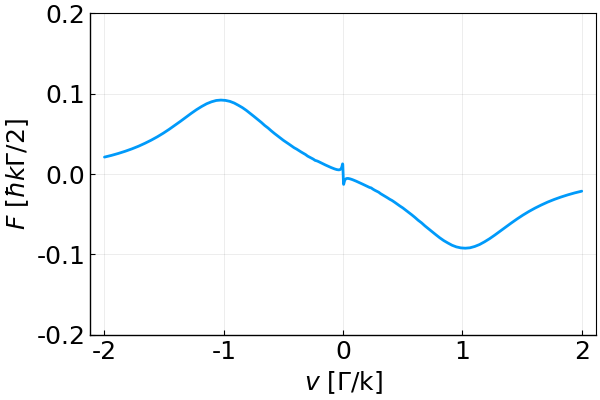

In [13]:
plot(vs, 2*forces,
    width = 2,
    ylim = (-0.2, 0.2),
    xlabel = L"$v$ [$\Gamma$/k]",
    ylabel = L"$F$ [$\hbar k\Gamma/2$]",
    frame = true,
    xtickfont = font(15),
    ytickfont = font(15),
    xaxis = font(18),
    yaxis = font(18),
    label = "")

Compare this to Fig. 7 from the [paper by Jean Dalibard and Claude Cohen-Tannoudji](https://www.osapublishing.org/josab/abstract.cfm?uri=josab-6-11-2023) (beware that the y-axis differs by a factor of 2):

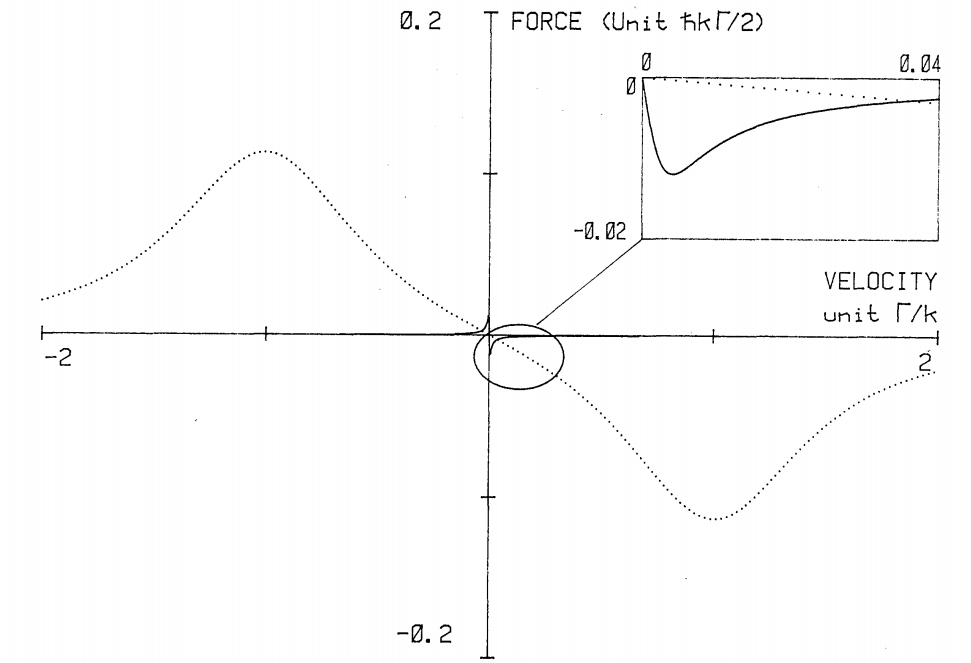

### Steady state convergence & behavior
How does the system converge to the steady state, and what are the population distributions there? Here we can check whether the time limits set in the calculation above are good enough.

In [14]:
vᵤ = 0.04;
ψ₀ = Ket(sbasis, sqrt.([0.5; 0.5; zeros(nStates - 2)]));
Tₘ = 2*π*2 / abs(vᵤ);
T = [0:0.01:Tₘ;];
Hₜ = (t, ρ) -> (H(vᵤ * t), L, Ldagger);
tout, ρₜ = timeevolution.master_dynamic(T, ψ₀, Hₜ; rates = rate);

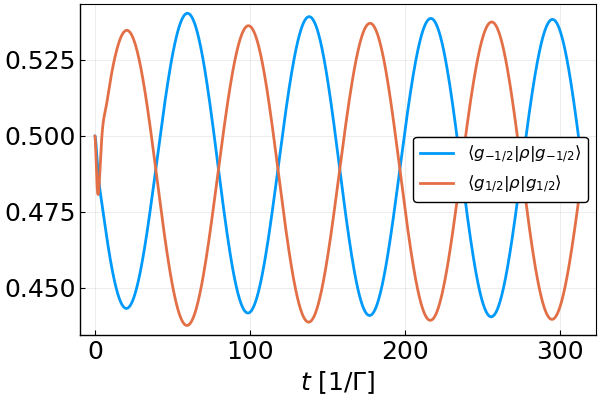

In [15]:
plot(tout, real(expect(DenseOperator(sbasis, Diagonal([1.; zeros(nStates - 1)])), ρₜ)), label = L"$\langle g_{-1/2} | \rho | g_{-1/2} \rangle$", width = 2)
plot!(tout, real(expect(DenseOperator(sbasis, Diagonal([0.; 1.; zeros(nStates - 2)])), ρₜ)), label = L"$\langle g_{1/2} | \rho | g_{1/2} \rangle$",
    frame = true,
    width = 2,
    xlabel = L"$t$ [$1/\Gamma$]",
    xtickfont = font(15),
    ytickfont = font(15),
    xaxis = font(18),
    yaxis = font(18),
    legendfont = font(12))

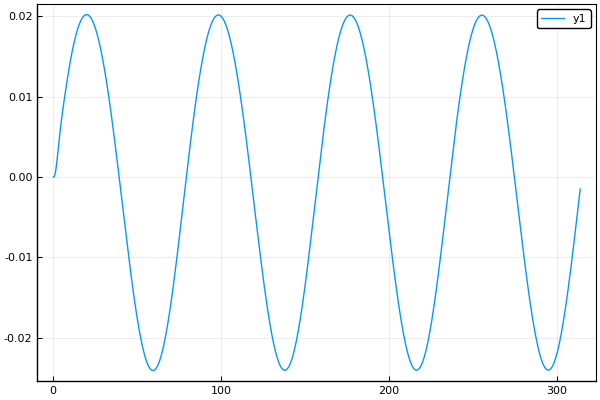

In [16]:
Fexpect = real( expect.(F.( vᵤ * tout ), ρₜ) )
plot(tout, Fexpect, frame = true)